<a id="top"></a>

# Finding M dwarf flares with TESS

***

# Learning goals
By the end of this tutorial, you will:
- Be able to identify M dwarf flares in TESS data.
- Understand what a periodogram is.
- Construct periodograms for high-cadence TESS light curves.
- Understand how to mask and process light curve data.
- Extract light curve time stamps corresponding to flares.

# Introduction
The flare rate of M dwarfs — the lowest-mass stars that undergo nuclear fusion — has a broad class of science cases. Flare rates have ramifications for stellar physics (e.g., connections to stellar mass and rotation period) and exoplanet science (e.g., photochemistry and habitability). Time-series MAST data can be used to capture and constrain flares. 

This tutorial continues a series exploring how to use MAST data for such purposes. In this portion, we will find flares in TESS data and use this to inform how we think about HST flares.

While this tutorial will result in some flare candidates, there are other to robust flare-detection (e.g., detrending with a spline fit, modeling the flare as a function of physical parameters) that are not depicted in this tutorial for the sake of brevity. These more advanced features are explored further in associated exercises.


(Arjun: reference the plotting exoplanet data notebook?)

# Imports
- numpy to help aggregate our metadata.
- matplotlib to plot our data
- sys (Python builtin) to read our machine's Python version.
- astropy to provide data structures that organize our metadata, units functionality, and coordinates functionality.
- lightkurve to download and manipulate our light curve data.

In [139]:
# download the list
import pandas as pd

from astropy.coordinates import position_angle

import matplotlib.pyplot as plt

from urllib.error import HTTPError

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord


import numpy as np
from astropy.timeseries import LombScargle
import astropy.io.fits as fits
from astropy.table import Table, vstack, unique

import lightkurve
from astropy.convolution import Gaussian1DKernel, Box1DKernel, convolve

# Main Contents

## Overview of flare-detection steps
- remove strong periodicity with lomb-scargle given some steps, max 3 times.
- iteratively mask out 3 sigma outliers.
- detect flares as at least 6 minutes of flux above 3 sigma threshold.

## Download data

Our first step is to take a look at what `lightkurve` data is available for Proxima Centauri (in keeping with our other flares notebook). (Reference download_transiting_planet notebook, or describe the output here?)

In [6]:
star = 'Proxima Centauri'

search_result = lightkurve.search_lightcurve(star)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,388857263,0.0
1,TESS Sector 11,2019,TESS-SPOC,1800,388857263,0.0
2,TESS Sector 11,2019,QLP,1800,388857263,0.0
3,TESS Sector 12,2019,SPOC,120,388857263,0.0
4,TESS Sector 12,2019,TESS-SPOC,1800,388857263,0.0
5,TESS Sector 12,2019,QLP,1800,388857263,0.0
6,TESS Sector 38,2021,SPOC,20,388857263,0.0
7,TESS Sector 38,2021,SPOC,120,388857263,0.0
8,TESS Sector 38,2021,SPOC,120,1019422496,0.0


To keep things simple, let's just download and plot the first light curve.

In [ ]:
# todo: run this for a bunch of stars.
# see if caught with jwst stuff.

In [96]:
lightcurve = search_result[3].download()
lightcurve

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1624.9594594235243,1.4645339e+05,4.5901649e+01,4.1260743e-03,286200,376.08346,1456.99583,1.3752986e+05,4.1709118e+01,7.5789971e+03,1.0004111e+01,1.4645339e+05,4.5901649e+01,10000000000000,———,———,———,———,376.08346,2.5492217e-04,1456.99583,2.3157275e-04,3.6354028e-02,-7.2659045e-02
1624.9608483029745,1.4634177e+05,4.5892078e+01,4.1260654e-03,286201,376.08595,1456.99873,1.3742131e+05,4.1700417e+01,7.6132451e+03,1.0017588e+01,1.4634177e+05,4.5892078e+01,10000000000000,———,———,———,———,376.08595,2.5512118e-04,1456.99873,2.3170107e-04,3.8899820e-02,-6.9650136e-02
1624.9622371824255,1.4644866e+05,4.5918671e+01,4.1260566e-03,286202,376.08463,1457.00076,1.3758127e+05,4.1724583e+01,7.6112329e+03,1.0021651e+01,1.4644866e+05,4.5918671e+01,10000000000000,———,———,———,———,376.08463,2.5497790e-04,1457.00076,2.3152262e-04,3.7557870e-02,-6.6152826e-02
1624.963626061876,1.4640534e+05,4.5915543e+01,4.1260477e-03,286203,376.08515,1457.00546,1.3753088e+05,4.1721741e+01,7.6391045e+03,1.0028797e+01,1.4640534e+05,4.5915543e+01,10000000000000,———,———,———,———,376.08515,2.5508966e-04,1457.00546,2.3168085e-04,3.9006885e-02,-6.1389577e-02
1624.9650149408615,1.4649520e+05,4.5916542e+01,4.1260384e-03,286204,376.08857,1456.99330,1.3751061e+05,4.1722649e+01,7.6541885e+03,1.0035028e+01,1.4649520e+05,4.5916542e+01,10000000000000,———,———,———,———,376.08857,2.5518713e-04,1456.99330,2.3159268e-04,4.1771129e-02,-7.5207263e-02
1624.966403820312,1.4639138e+05,4.5925682e+01,4.1260296e-03,286205,376.08647,1457.00597,1.3752825e+05,4.1730953e+01,7.6671724e+03,1.0049089e+01,1.4639138e+05,4.5925682e+01,10000000000000,———,———,———,———,376.08647,2.5515366e-04,1457.00597,2.3158280e-04,4.0113356e-02,-6.0267743e-02
1624.967792699763,1.4644305e+05,4.5917343e+01,4.1260207e-03,286206,376.08901,1456.99761,1.3744889e+05,4.1723377e+01,7.6856699e+03,1.0049611e+01,1.4644305e+05,4.5917343e+01,10000000000000,———,———,———,———,376.08901,2.5525255e-04,1456.99761,2.3196301e-04,4.2592224e-02,-7.0274062e-02
1624.9691815792137,1.4651642e+05,4.5949448e+01,4.1260119e-03,286207,376.08758,1457.00196,1.3759447e+05,4.1752548e+01,7.7336772e+03,1.0064578e+01,1.4651642e+05,4.5949448e+01,10000000000000,———,———,———,———,376.08758,2.5519307e-04,1457.00196,2.3167618e-04,4.0682416e-02,-6.5751553e-02


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

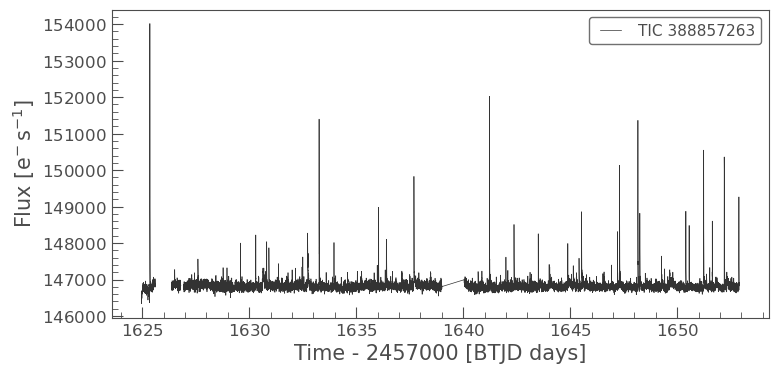

In [97]:
lightcurve.plot()

There's a pretty strong outlier evident; let's remove it and see how the resultant lightcurve looks.

In [98]:
lightcurve = lightcurve.remove_outliers(sigma=10)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

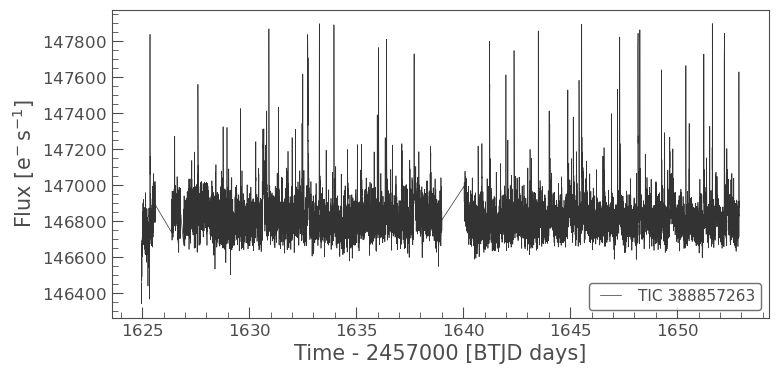

In [99]:
lightcurve.plot()

By eye, we can already tell that the baseline flux for this target exhibits some periodicity. In the next section, we will explore how to remove this periodicity to increase the sensitivity of our flares search.

# Periodogram analysis

First, we set up our periodogram object using our lightcurve-provided values.

In [100]:
ls = LombScargle(lightcurve.time.value, lightcurve.flux.value, dy=lightcurve.flux_err.value)


We then use the periodogram to derive the sinusoid that best describes the underlying variability in our data.

In [101]:
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

In [102]:
best_frequency

1.8936377766247705

In [25]:
lightcurve.time.value

array([1598.93407022, 1598.93545914, 1598.93684807, ..., 1623.89279743,
       1623.89418632, 1623.89557521])

If we overplot above-described sinusoid against our data, we can see that it does a decent job at describing some of the lowest-order variability.

Text(0, 0.5, 'Flux (e-)')

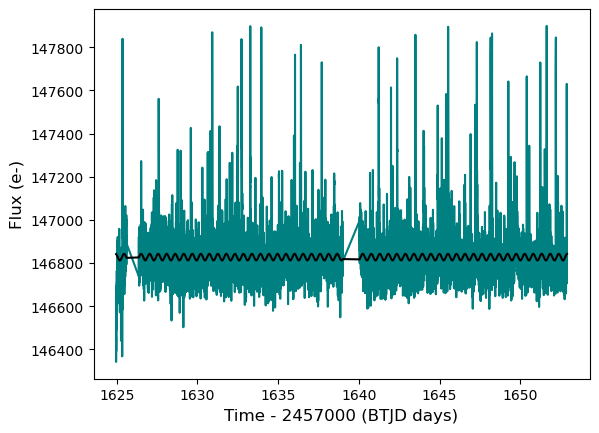

In [103]:
plt.plot(lightcurve.time.value, lightcurve.flux.value, color='teal')
plt.plot(lightcurve.time.value, y_fit, color='black')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

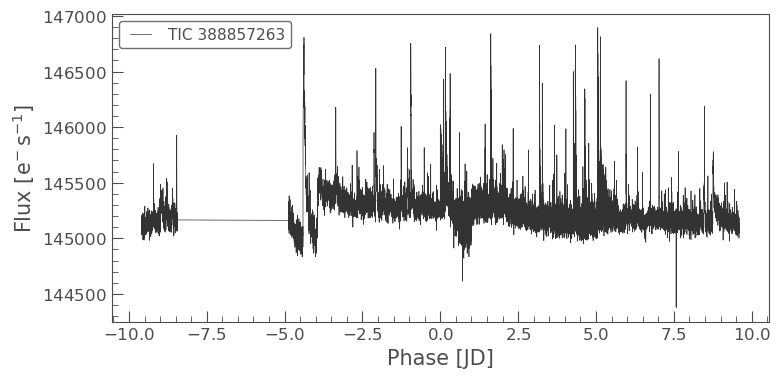

In [35]:
# for fun, we can fold at this period
lightcurve.fold(period=1/best_frequency).plot()

Dividing out this sinusoid yields a less variable dataset.

Text(0, 0.5, 'Flux (e-)')

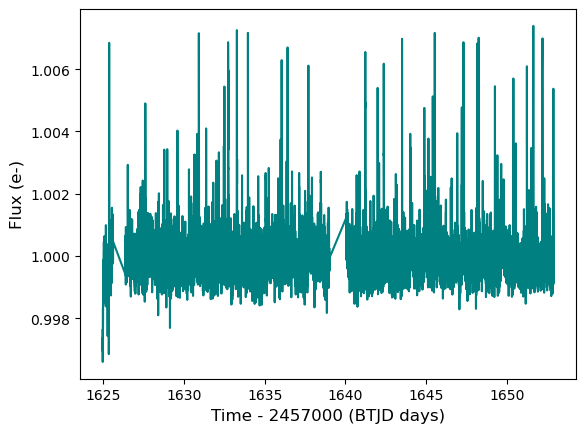

In [104]:
cleaned_once = lightcurve.flux.value/y_fit

plt.plot(lightcurve.time.value, cleaned_once, color='teal')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

There still might be periodicity within the data. Let's repeat the above process to see if we can find any more variability.

In [120]:
ls = LombScargle(lightcurve.time.value, cleaned_once)
frequency, power = ls.autopower(
                        nyquist_factor=2)


best_frequency = frequency[np.argmax(power)]
y_fit = ls.model(lightcurve.time.value, best_frequency)

How do we know that we're finding "real" periodicity? One measure is the [False Alarm Probability](https://docs.astropy.org/en/stable/timeseries/lombscargle.html#peak-significance-and-false-alarm-probabilities). This value loosely tells us the significance of a peak in the Lomb-Scargle periodogram. If the false alarm probability is (much less than one), then the chance of this "periodicity" being due to random noise is very low. 

In [122]:
ls.false_alarm_probability(power.max()) 

1.7565029432500157e-32

As another check we can check the power output of the Lomb-Scargle periodogram.

Text(0.5, 0, 'Period (days)')

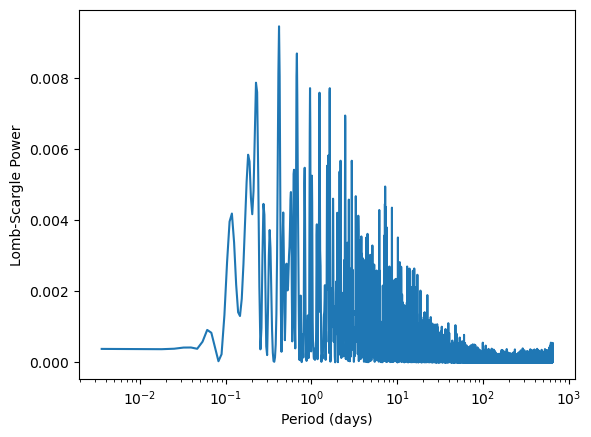

In [124]:
plt.plot(frequency, power)
plt.xscale('log')
plt.ylabel('Lomb-Scargle Power')
plt.xlabel('Period (days)')

There's nothing particularly alarming here, so we can continue onward.

Text(0, 0.5, 'Flux (e-)')

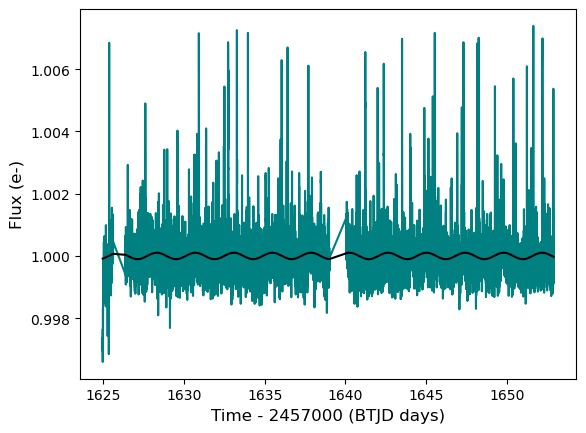

In [127]:
plt.plot(lightcurve.time.value, cleaned_once, color='teal')
plt.plot(lightcurve.time.value, y_fit, color='black')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

In [128]:
cleaned_twice = cleaned_once/y_fit

Text(0, 0.5, 'Flux (e-)')

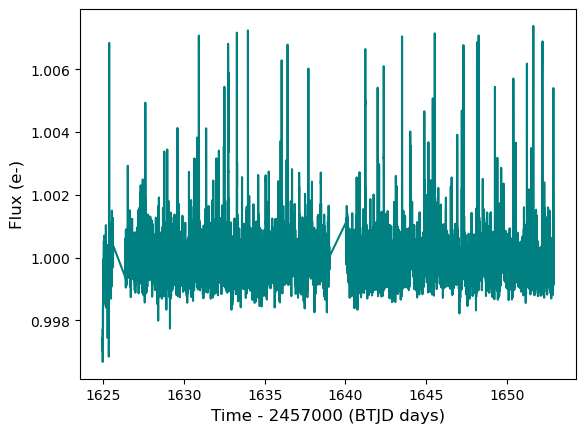

In [160]:
plt.plot(lightcurve.time.value,cleaned_twice, color='teal')
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

# Flare candidate detection

To detect flares in our data, we first need to divide by a running mean. This running mean can be computed by convolving our dataset with a 1D box kernel, with the width of the box corresponding to the region over which we'd like to calculate our running mean.

Text(0, 0.5, 'Flux (e-)')

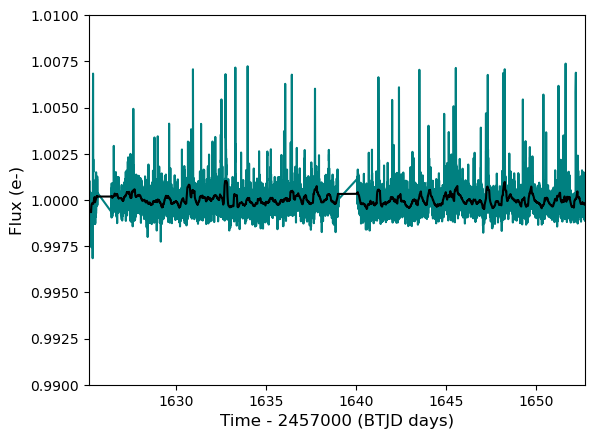

In [162]:
width = 128 # arjun: worth motivating?
mean_kernel = Box1DKernel(width=width)

running_mean = convolve(cleaned_twice, mean_kernel)

plt.plot(lightcurve.time.value, cleaned_twice, color='teal')

dt = np.diff(lightcurve.time.value)[0]

plt.plot(lightcurve.time.value, running_mean, color='black')

# zoom in and inspect a specific region
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)

plt.ylim(0.99, 1.01)
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

Next, we'd like to flag all those points with flux > 3 standard deviations above the running mean.

Text(0, 0.5, 'Flux (e-)')

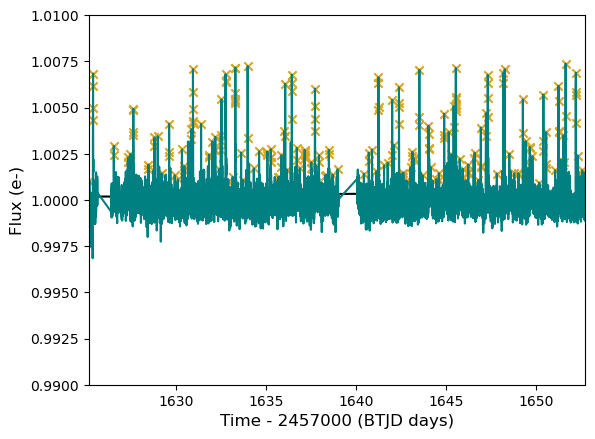

In [163]:
# calculate running standard deviation
sigma_2 = convolve(np.square(cleaned_twice - running_mean), g)

sigma =  np.sqrt(sigma_2)

plt.plot(lightcurve.time.value, z, color='black')
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width)



mask = cleaned_twice > z + 3 * sigma

plt.scatter(lightcurve.time.value[mask], cleaned_twice[mask], marker='x', color='goldenrod')



plt.plot(lightcurve.time.value, cleaned_twice, color='teal')
plt.ylim(0.99, 1.01)
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

Finally, we only consider these events flares if they last longer than 6 minutes. In these data, this corresonds to spanning more than 3 data points.

In [164]:
ticker = 0
ticker_arr = []

# only check within the high-flux regions
for m in mask:
    if m:
        ticker += 1
    else:
        ticker = 0
    ticker_arr += [ticker]

In [165]:
other_mask = np.array(ticker_arr) >= 3

Text(0, 0.5, 'Flux (e-)')

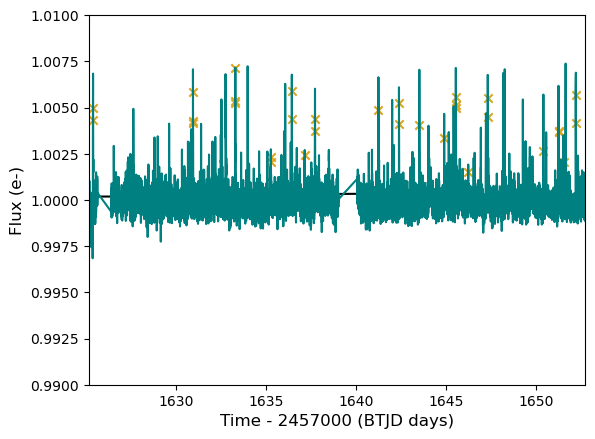

In [168]:
plt.plot(lightcurve.time.value, z, color='black', )
plt.xlim(lightcurve.time.value.min() + dt * width, lightcurve.time.value.max() - dt * width,)


plt.scatter(lightcurve.time.value[other_mask], cleaned_twice[other_mask], marker='x', color='goldenrod')



plt.plot(lightcurve.time.value, cleaned_twice,color='teal')
plt.ylim(0.99, 1.01)
plt.xlabel('Time - 2457000 (BTJD days)', fontsize=12)
plt.ylabel('Flux (e-)', fontsize=12)

## Write timestamps

With our flares detected, we can finally write the timestamps to a file. These data then then be compared to other datasets — e.g., by searching for HST datasets to see if any exposures have been taken near flare events.

In [148]:
formatted_days = lightcurve.time.value[other_mask] + 2457000 # these are in BTJD days

np.save(f'flare_timestamps_{star}.npy', formatted_days)

# Exercises
1. Try these steps for another star.
2. Add a spline-fit detrending step to the flare-detection pipeline.
3. Perform injection/recovery tests in the flare-detection pipeline.
4. Identify "outburst flares," as described by Günther et al. 2020: "... iterate through all flare events sorted in time. For a given flare, if there is no other candidate peak one hour before or three hours after the event, the outburst is labeled as containing only this single flare. When there are other flares following, the outburst epoch gets expanded accordingly. As a result, outburst epochs span from 1 hr before their earliest flare peak to 3 hr after their latest flare peak."
4. Loop this pipeline over many stars. Try to construct a flare rate vs. stellar rotation period diagram for all known M dwarf exoplanet hosts.
5. Connect this to the HST timestamps for a single M dwarf (e.g., Proxima Centauri) — are there any overlaps?
6. Estimate the energy associated with an individual flare.

# Additional Resources
- Give a few flares papers
- give a few TESS papers
- convolution resources
- periodogram resources


# About this Notebook

**Author**: Arjun B. Savel (asavel@umd.edu).

**Last updated**: 2022-09-28

# Citations
If you use `astropy`, `lightkurve`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citing `astropy`,
`lightkurve`, and `numpy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](https://docs.lightkurve.org/about/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
